Sentiment analysis, also referred to as opinion mining, is an approach to natural language processing (NLP) that identifies the emotional tone behind a body of text. This is a popular way for organizations to determine and categorize opinions about a product, service, or idea.                           
In addition to identifying sentiment, opinion mining can extract the polarity (or the amount of positivity and negativity), subject and opinion holder within the text.

We have two datasets twitter and reddit reviews which we will use to train the model. Later we can extract tweets from twitter to check their sentiments using the model.

In [3]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,ENGLISH_STOP_WORDS
import nltk
from nltk.stem import PorterStemmer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud

import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dropout, Dense, Flatten
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import sparse_categorical_crossentropy

import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Importing datasets

Reddit_data = pd.read_csv('./Dataset/Reddit_data.csv')
Twitter_data = pd.read_csv('./Dataset/Twitter_data.csv')
Apple_data = pd.read_csv('./Dataset/apple-twitter-sentiment-texts.csv')

In [6]:
# Reddit data features
Reddit_data.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [7]:
# Twitter data features
Twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [8]:
# Twitter data features
Apple_data.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [9]:
# Number of rows and columns in both the dataset
Reddit_data.shape, Twitter_data.shape, Apple_data.shape

((37249, 2), (162980, 2), (1630, 2))

We will concat all the datasets

In [10]:
# Renaming the column from reddit dataset

Reddit_data.rename(columns = {'clean_comment':'clean_text'}, inplace = True)
Apple_data.rename(columns = {'text':'clean_text', 'sentiment': 'category'}, inplace = True)

In [11]:
# Joining the two datasets
dataset = pd.concat([Reddit_data, Twitter_data, Apple_data], ignore_index = True)

In [12]:
# Final dataset dimension
dataset.shape

(201859, 2)

In [13]:
# Descriptive statistics 
dataset.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
clean_text,201755,201339,,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,201852.0,NaN,NaN,NaN,0.216743,0.781293,-1.0,0.0,0.0,1.0,1.0


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201859 entries, 0 to 201858
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  201755 non-null  object 
 1   category    201852 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


In [15]:
# Checking for null values 

dataset.isnull().sum()

clean_text    104
category        7
dtype: int64

In [16]:
for i in dataset.columns:
    mv = np.round((dataset[i].isnull().sum() / dataset.shape[0])*100 , 3)
    print(f'Missing value % in {i} : {mv} %')

Missing value % in clean_text : 0.052 %
Missing value % in category : 0.003 %


We will remove these null rows 

In [17]:
dataset.dropna(inplace = True)

In [18]:
dataset.isnull().sum()  # All null values removed

clean_text    0
category      0
dtype: int64

In [19]:
# Checking for duplicates

dataset.duplicated().sum()

416

In [20]:
dataset.drop_duplicates(inplace = True, ignore_index = True) # Removing the duplicated rows

In [21]:
# Lets check the final dataset shape

dataset.shape

(201332, 2)

In [22]:
# Checking features

dataset.columns.values

array(['clean_text', 'category'], dtype=object)

Clean text are the comments and category is the sentiment value for the comment whether positive (1), negative (-1) or nuetral(0)

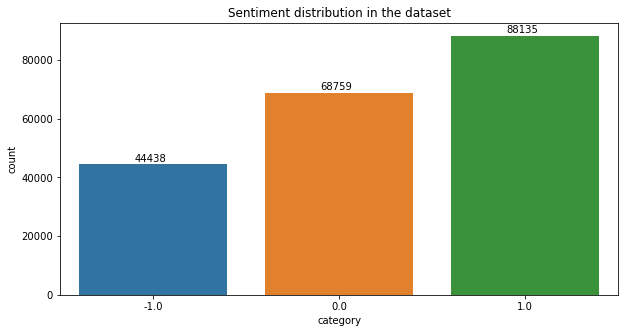

In [23]:
# Countplot 

plt.figure(figsize = (10,5))
plt.title('Sentiment distribution in the dataset')
countplot = sns.countplot(dataset.category)

values = dataset.category.value_counts().values
loc = 2

for i in values:
    countplot.annotate(i, xy = (loc-0.1, i+1000))
    loc -= 1

plt.show()

There are relatively more number of postive comments around 88000 in the dataset followed by 68000 neutral comments and only 44000 negative comments

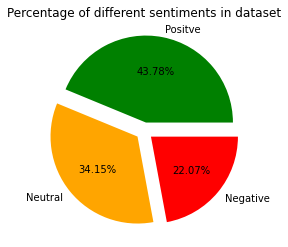

In [24]:
# PieChart

data = dataset.category.value_counts().values
explode = [0.1, 0.1, 0.1]
colors = ['green', 'orange', 'red']
labels = ['Positve', 'Neutral', 'Negative']

plt.pie(x = data, labels = labels, explode = explode, autopct = '%0.2f%%', colors = colors)
plt.title('Percentage of different sentiments in dataset')
plt.show()

### WordCloud

Checking the words which most represent postive, negative and neutral sentiments in the comments

In [25]:
# Splitting the dataset according to sentiments

pos_data = dataset[dataset.category == 1]
neg_data = dataset[dataset.category == -1]
neut_data = dataset[dataset.category == 0]

In [26]:
pos_data.shape, neg_data.shape, neut_data.shape

((88135, 2), (44438, 2), (68759, 2))

In [27]:
def text_to_wordcloud(data, senti):
    stopwards = list(ENGLISH_STOP_WORDS)
    
    data = " ".join(data.clean_text)
    WC = WordCloud(stopwords = stopwards, max_words = 50)
    wc = WC.generate(data)
    
    plt.figure(figsize = (10,5))
    plt.imshow(wc, interpolation = 'antialiased')
    
    plt.title(f'WordCloud for {senti} Sentiments') 
    plt.show()

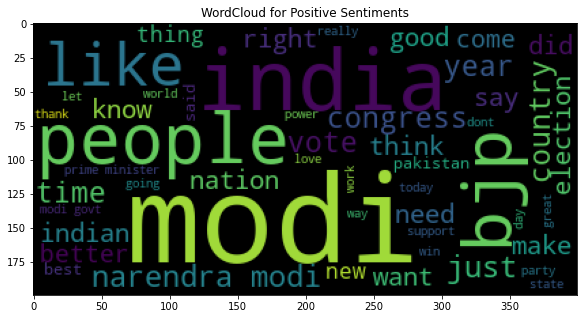

In [28]:
text_to_wordcloud(pos_data, 'Positive')

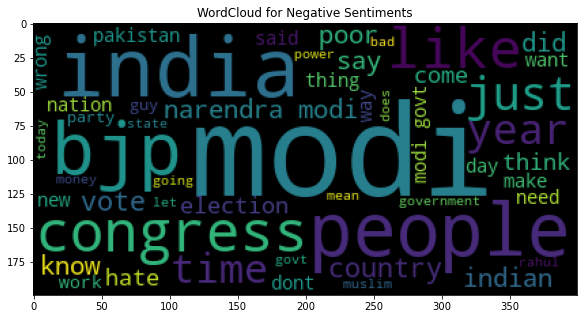

In [29]:
text_to_wordcloud(neg_data, 'Negative')

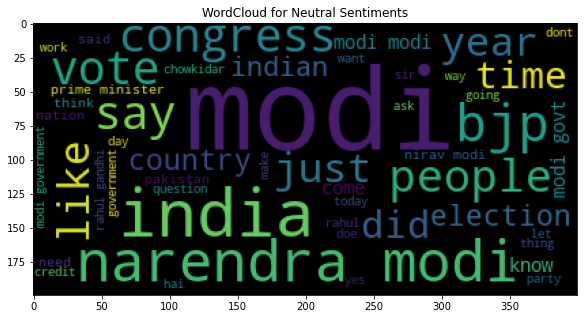

In [30]:
text_to_wordcloud(neut_data, 'Neutral')

## Pre Processing the Texts

In [31]:
dataset.head(), dataset.tail()

(                                          clean_text  category
 0   family mormon have never tried explain them t...       1.0
 1  buddhism has very much lot compatible with chr...       1.0
 2  seriously don say thing first all they won get...      -1.0
 3  what you have learned yours and only yours wha...       0.0
 4  for your own benefit you may want read living ...       1.0,
                                                clean_text  category
 201327     Those** PICK UP THE SLACK YOU FUCK BOYS @Apple      -1.0
 201328  Finally got my iPhone 6 in the mail and it com...      -1.0
 201329  @umo_games @Apple ended up getting a new compu...       0.0
 201330  The 19-Year-Old #WizKid Who Turned Down @Apple...       0.0
 201331  The iPhone 6 May Have A Longer Upgrade Cycle -...      -1.0)

We need to clean the dataset before using it for model training like removing stopwards, stemming or lemmatizing the texts removing punctuations 

In [301]:
# Stopwards 

print(len(ENGLISH_STOP_WORDS))
print(list(ENGLISH_STOP_WORDS))

# Storing stopwards to variable
stopwards = list(ENGLISH_STOP_WORDS)

# removing some of the negative stopwards from the list 

to_remove = ['not', 'nobody', 'no', 'interest', 'cannot', 'neither', 'never', 'nowhere', 'without']
for i in to_remove:
    stopwards.remove(i)

318
['seemed', 'therein', 'toward', 'anything', 'un', 'last', 'also', 'due', 'thus', 'why', 'not', 'only', 'own', 'latter', 'con', 'some', 'most', 'after', 'nevertheless', 'we', 'together', 'eleven', 'forty', 'as', 'though', 'even', 'our', 'may', 'give', 'against', 'through', 'thereby', 'go', 'former', 'keep', 'somewhere', 'six', 'front', 'which', 'etc', 'am', 'ever', 'except', 'it', 'its', 'amoungst', 'system', 'they', 'moreover', 'the', 'whoever', 'herein', 'five', 'down', 'along', 'else', 'about', 'something', 'twelve', 'onto', 'part', 'but', 'mostly', 'everyone', 'still', 'between', 'until', 'fifteen', 'then', 'nobody', 'behind', 'what', 'there', 'i', 'always', 'their', 'are', 'full', 'a', 'fill', 'where', 'describe', 'than', 'or', 'all', 'anywhere', 'per', 'sometime', 'whenever', 'within', 'him', 'seeming', 'hasnt', 'become', 'now', 'same', 'seem', 'no', 'amount', 'since', 'among', 'four', 'such', 'other', 'whole', 'mine', 'interest', 'towards', 'therefore', 'very', 'twenty', 'bei

In [302]:
# Defining function to clean the dataset

def clean_data(data):
    
    urlPattern = r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*|(#)[^ ]*|($)[^ ]*)'
    data = re.sub(urlPattern, '', data)
    
    data = re.sub(r"(\'t)|(\'nt)", ' not', data)
    data = re.sub(r'hasnt', 'has not', data)
    data = re.sub(r'couldnt', 'could not', data)
    data = re.sub(r'cant', 'can not', data)
    
    data = re.sub(r'[^a-zA-Z]', ' ', data)
    data = data.lower()
    
    tokens = data.split()
    tokens = [token for token in tokens if token not in stopwards]
    tokens = [PorterStemmer().stem(word) for word in tokens]
    tokens = [token for token in tokens if len(token) > 2]
    
    return tokens

In [303]:
# Output before and after cleaning the text 

print(dataset.clean_text[0])
clean_data(dataset.clean_text[0])

 family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches 


['famili',
 'mormon',
 'never',
 'tri',
 'explain',
 'stare',
 'puzzl',
 'time',
 'time',
 'like',
 'kind',
 'strang',
 'creatur',
 'nonetheless',
 'come',
 'admir',
 'patienc',
 'calm',
 'equanim',
 'accept',
 'compass',
 'develop',
 'thing',
 'buddhism',
 'teach']

In [304]:
print(dataset.clean_text[201331])
clean_data(dataset.clean_text[201331])

The iPhone 6 May Have A Longer Upgrade Cycle - If So, Expect Unit Sales To Fall $AAPL #aapl
http://t.co/eP1ZksHNqJ


['iphon', 'longer', 'upgrad', 'cycl', 'expect', 'unit', 'sale', 'fall', 'aapl']

## TFIDF Vectorizer 

In [365]:
# Tfidf vectorizer

tfidf = TfidfVectorizer(max_features = 15000, tokenizer = clean_data)
X = tfidf.fit_transform(dataset.clean_text)
Y = dataset.category

## Count Vectorizer

In [366]:
# CountVectorizer

tf = CountVectorizer(max_features = 15000, tokenizer = clean_data)
X_c = tf.fit_transform(dataset.clean_text)

## Train Test Split

In [367]:
# Train Test split

# train_test using tfidf vectorizer
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0, stratify = Y)

# train_test using count vectorizer
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X_c, Y, test_size = 0.25, random_state = 0, stratify = Y)

# Dimensions
print('X_Train data: ', x_train.shape), 
print('X_Test data: ', x_test.shape),
print('X_Train data_c: ', x_train_c.shape), 
print('X_Test data_c: ', x_test_c.shape), 
print('Y_Train data: ', y_train.shape), 
print('Y_Test data: ', y_test.shape)

X_Train data:  (150999, 15000)
X_Test data:  (50333, 15000)
X_Train data_c:  (150999, 15000)
X_Test data_c:  (50333, 15000)
Y_Train data:  (150999,)
Y_Test data:  (50333,)


## SVM Algorithm

In [368]:
# Using Tfidf Vectorizer data 

svc = LinearSVC()   # Inititalizing the SVM classifier

svc.fit(x_train, y_train)   # Fitting the model to train data

y_svc_1 = svc.predict(x_test) # Predicting using test 

svc_acc_1 = accuracy_score(y_svc_1, y_test)

print(f'Accuracy: {svc_acc_1 * 100:.2f} %')
print(f'\nClassification Report:\n\n {classification_report(y_svc_1, y_test)}')
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, y_svc_1)}')

svc_f1_score_1 = f1_score(y_test, y_svc_1, average = 'weighted')
print(f'F1 Score: \n\n {svc_f1_score_1}')

Accuracy: 81.77 %

Classification Report:

               precision    recall  f1-score   support

        -1.0       0.71      0.80      0.75      9850
         0.0       0.89      0.78      0.84     19592
         1.0       0.81      0.86      0.83     20891

    accuracy                           0.82     50333
   macro avg       0.81      0.81      0.81     50333
weighted avg       0.82      0.82      0.82     50333

Confusion Matrix: 

 [[ 7898  1455  1756]
 [  582 15365  1243]
 [ 1370  2772 17892]]
F1 Score: 

 0.8166106612419698


In [369]:
# Using CountVectorizer data 

svc = LinearSVC()   # Inititalizing the SVM classifier

svc.fit(x_train_c, y_train_c)   # Fitting the model to train data

y_svc_2 = svc.predict(x_test_c) # Predicting using test 

svc_acc_2 = accuracy_score(y_svc_2, y_test_c)

print(f'Accuracy: {svc_acc_2 * 100:.2f} %')
print(f'\nClassification Report:\n\n {classification_report(y_svc_2, y_test_c)}')
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test_c, y_svc_2)}')

svc_f1_score_2 = f1_score(y_test, y_svc_2, average = 'weighted')
print(f'F1 Score: \n\n {svc_f1_score_2}')

Accuracy: 81.10 %

Classification Report:

               precision    recall  f1-score   support

        -1.0       0.72      0.78      0.75     10260
         0.0       0.88      0.78      0.83     19311
         1.0       0.80      0.85      0.83     20762

    accuracy                           0.81     50333
   macro avg       0.80      0.80      0.80     50333
weighted avg       0.82      0.81      0.81     50333

Confusion Matrix: 

 [[ 7971  1418  1720]
 [  699 15150  1341]
 [ 1590  2743 17701]]
F1 Score: 

 0.810292880208384


## Naive Bayes Algorithm

In [370]:
# Using Tfidf Vectorizer data 

cnb = ComplementNB()   # Inititalizing the Multinomial Naive Bayes classifier

cnb.fit(x_train, y_train)  
y_cnb_1 = cnb.predict(x_test)

cnb_acc_1 = accuracy_score(y_cnb_1, y_test)

print(f'Accuracy: {cnb_acc_1 * 100:.2f} %')

print(f'\n Classification Report:\n\n {classification_report(y_cnb_1, y_test)}')

print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, y_cnb_1)}')

cnb_f1_score_1 = f1_score(y_test, y_cnb_1,  average = 'weighted')
print(f'F1 Score: \n\n {cnb_f1_score_1}')

Accuracy: 69.71 %

 Classification Report:

               precision    recall  f1-score   support

        -1.0       0.71      0.59      0.64     13317
         0.0       0.65      0.69      0.67     16220
         1.0       0.73      0.77      0.75     20796

    accuracy                           0.70     50333
   macro avg       0.70      0.68      0.69     50333
weighted avg       0.70      0.70      0.70     50333

Confusion Matrix: 

 [[ 7877  1570  1662]
 [ 2879 11194  3117]
 [ 2561  3456 16017]]
F1 Score: 

 0.6986256265673996


In [371]:
# Using CountVectorizer data 

cnb = ComplementNB()   # Inititalizing the Multinomial Naive Bayes classifier

cnb.fit(x_train_c, y_train_c)  
y_cnb_2 = cnb.predict(x_test_c)

cnb_acc_2 = accuracy_score(y_cnb_2, y_test_c)

print(f'Accuracy: {cnb_acc_2 * 100:.2f} %')
print(f'\n Classification Report:\n\n {classification_report(y_cnb_2, y_test_c)}')
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test_c, y_cnb_2)}')

cnb_f1_score_2 = f1_score(y_test, y_cnb_2,  average = 'weighted')
print(f'F1 Score: \n\n {cnb_f1_score_2}')

Accuracy: 70.06 %

 Classification Report:

               precision    recall  f1-score   support

        -1.0       0.69      0.60      0.64     12808
         0.0       0.67      0.69      0.68     16681
         1.0       0.73      0.77      0.75     20844

    accuracy                           0.70     50333
   macro avg       0.70      0.69      0.69     50333
weighted avg       0.70      0.70      0.70     50333

Confusion Matrix: 

 [[ 7677  1663  1769]
 [ 2750 11475  2965]
 [ 2381  3543 16110]]
F1 Score: 

 0.7020481897432025


## Logistic Regression

In [372]:
# Using Tfidf Vectorizer data 

lr = LogisticRegression()   # Inititalizing the Logistic Regression classifier

lr.fit(x_train, y_train)  
y_lr_1 = lr.predict(x_test)

lr_acc_1 = accuracy_score(y_lr_1, y_test)

print(f'Accuracy: {lr_acc_1 * 100:.2f} %')
print(f'\n Classification Report:\n\n {classification_report(y_lr_1, y_test)}')
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, y_lr_1)}')

lr_f1_score_1 = f1_score(y_test, y_lr_1,  average = 'weighted')
print(f'F1 Score: \n\n {lr_f1_score_1}')

Accuracy: 81.52 %

 Classification Report:

               precision    recall  f1-score   support

        -1.0       0.69      0.81      0.74      9447
         0.0       0.90      0.77      0.83     20129
         1.0       0.81      0.86      0.83     20757

    accuracy                           0.82     50333
   macro avg       0.80      0.81      0.80     50333
weighted avg       0.82      0.82      0.82     50333

Confusion Matrix: 

 [[ 7639  1712  1758]
 [  494 15545  1151]
 [ 1314  2872 17848]]
F1 Score: 

 0.8137413093110253


In [373]:
# Using CountVectorizer data 

lr = LogisticRegression()   # Inititalizing the Logistic Regression classifier

lr.fit(x_train_c, y_train_c)  
y_lr_2 = lr.predict(x_test_c)

lr_acc_2 = accuracy_score(y_lr_2, y_test_c)

print(f'Accuracy: {lr_acc_2 * 100:.2f} %')
print(f'\n Classification Report:\n\n {classification_report(y_lr_2, y_test_c)}')
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test_c, y_lr_2)}')

lr_f1_score_2 = f1_score(y_test, y_lr_2,  average = 'weighted')
print(f'F1 Score: \n\n {lr_f1_score_2}')

Accuracy: 82.04 %

 Classification Report:

               precision    recall  f1-score   support

        -1.0       0.72      0.79      0.75     10092
         0.0       0.90      0.79      0.84     19520
         1.0       0.81      0.86      0.83     20721

    accuracy                           0.82     50333
   macro avg       0.81      0.82      0.81     50333
weighted avg       0.83      0.82      0.82     50333

Confusion Matrix: 

 [[ 7991  1377  1741]
 [  560 15477  1153]
 [ 1541  2666 17827]]
F1 Score: 

 0.8194118439913085


In [374]:
# Comparing the results for different models

acc_df = pd.DataFrame()
acc_df['Model'] = ['SVM', 'Naive Bayes', 'Logistic Regression']

acc_df['Tfidf Vectorizer Accuracy'] = [svc_acc_1, cnb_acc_1, lr_acc_1]
acc_df['Tfidf Vectorizer F1 Score'] = [svc_f1_score_1, cnb_f1_score_1, lr_f1_score_1]

acc_df['Count Vectorizer Accuracy'] = [svc_acc_2, cnb_acc_2, lr_acc_2]
acc_df['Count Vectorizer F1 Score'] = [svc_f1_score_2, cnb_f1_score_2, lr_f1_score_2]
acc_df.set_index('Model')

,Tfidf Vectorizer Accuracy,Tfidf Vectorizer F1 Score,Count Vectorizer Accuracy,Count Vectorizer F1 Score
Model,,,,
SVM,0.817654,0.816611,0.811038,0.810293
Naive Bayes,0.697117,0.698626,0.700574,0.702048
Logistic Regression,0.815211,0.813741,0.820436,0.819412


Using CountVectorizer gives slightly better results compared to TFIDF Vectorizer

Maximum accuracy we get is using SVM which is around 83 %.      
This is a good accuracy but we hope to get better results using Neural Networks (LSTM)

## LSTM

In [375]:
# Defining function to clean the dataset and joining 

def clean_data(data):
    
    urlPattern = r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*|(#)[^ ]*|($)[^ ]*)'
    data = re.sub(urlPattern, '', data)
    
    data = re.sub(r"(\'t)|(\'nt)", ' not', data)
    data = re.sub(r'hasnt', 'has not', data)
    data = re.sub(r'couldnt', 'could not', data)
    data = re.sub(r'cant', 'can not', data)
    
    data = re.sub(r'[^a-zA-Z]', ' ', data)
    data = data.lower()
    
    tokens = data.split()
    tokens = [token for token in tokens if token not in stopwards]
    tokens = [PorterStemmer().stem(word) for word in tokens]
    tokens = [token for token in tokens if len(token) > 2]
    
    final_data = ' '.join(tokens)
    
    return final_data

In [376]:
# Tokeninzing the clean text and then sequencing 

clean_text = dataset.clean_text.apply(clean_data_join)

tokenize = Tokenizer(num_words = 15000)
tokenize.fit_on_texts(clean_text)

new_clean_text = tokenize.texts_to_sequences(clean_text)

In [377]:
len(tokenize.word_index)

100625

In [378]:
# Padding the data to get equal length of data

new_clean_text = pad_sequences(new_clean_text, maxlen = 120, padding = 'post', truncating = 'post')

In [379]:
new_clean_text

array([[  84,   68,  521, ...,    0,    0,    0],
       [3148,  123, 6975, ...,    0,    0,    0],
       [ 665,   52,    9, ...,    0,    0,    0],
       ...,
       [ 355,  263,  243, ...,    0,    0,    0],
       [  15,  284,  298, ...,    0,    0,    0],
       [1904, 1521, 2280, ...,    0,    0,    0]])

In [380]:
# Label Encoding the category

y = dataset.category.map({-1: 0, 0: 1, 1: 2})

In [381]:
# Train Test Split 

x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(new_clean_text, y, test_size = 0.25, random_state = 0, stratify = y)
x_train_lstm, x_val_lstm, y_train_lstm, y_val_lstm = train_test_split(x_train_lstm, y_train_lstm, test_size = 0.2, random_state = 0, stratify = y_train_lstm)

print('x_train:',(x_train_lstm.shape))
print('y_train:',(y_train_lstm.shape))
print('x_val:',(x_val_lstm.shape))
print('y_val:',(y_val_lstm.shape))
print('x_test:',(x_test_lstm.shape))
print('y_test:',(y_test_lstm.shape))

x_train: (120799, 120)
y_train: (120799,)
x_val: (30200, 120)
y_val: (30200,)
x_test: (50333, 120)
y_test: (50333,)


In [382]:
# Model Building

model = Sequential()

model.add(Embedding(len(tokenize.word_index), input_length = 120 , output_dim = 50))
model.add(Bidirectional(LSTM(100)))
model.add(Flatten())

model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.2)) 
model.add(Dense(3, activation = 'softmax'))

model.compile('adam', loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 50)           5031250   
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              120800    
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 250)               50250     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 753       
                                                      

In [383]:
# Early Stopping to stop the iterations 

callback = EarlyStopping(monitor = 'val_loss', patience = 5)

In [384]:
# Fitting the model

model_result = model.fit(x_train_lstm , y_train_lstm , batch_size = 250, epochs = 10,
                    validation_data = (x_val_lstm , y_val_lstm), callbacks = [callback] )

Epoch 1/10
484/484 [==============================] - 477s 972ms/step - loss: 0.6305 - accuracy: 0.7407 - val_loss: 0.4857 - val_accuracy: 0.8214
Epoch 2/10
484/484 [==============================] - 429s 887ms/step - loss: 0.4469 - accuracy: 0.8375 - val_loss: 0.4756 - val_accuracy: 0.8288
Epoch 3/10
484/484 [==============================] - 464s 960ms/step - loss: 0.4178 - accuracy: 0.8507 - val_loss: 0.4794 - val_accuracy: 0.8224
Epoch 4/10
484/484 [==============================] - 465s 960ms/step - loss: 0.3915 - accuracy: 0.8586 - val_loss: 0.4969 - val_accuracy: 0.8190
Epoch 5/10
484/484 [==============================] - 445s 920ms/step - loss: 0.3585 - accuracy: 0.8704 - val_loss: 0.5149 - val_accuracy: 0.8182
Epoch 6/10
484/484 [==============================] - 429s 886ms/step - loss: 0.3200 - accuracy: 0.8832 - val_loss: 0.5615 - val_accuracy: 0.8087
Epoch 7/10
484/484 [==============================] - 428s 884ms/step - loss: 0.2844 - accuracy: 0.8949 - val_loss: 0.6366 -

In [385]:
# Using the model to predict on test data

model.evaluate(x_test_lstm, y_test_lstm, batch_size = 50)

1007/1007 [==============================] - 73s 72ms/step - loss: 0.6488 - accuracy: 0.8105


[0.6487923264503479, 0.8105418086051941]

LSTM Model gives an accuracy of 81.05 %.          
The low accuracy may be due to imbalance between multi class data

Comparing all traditional and neural network model, logistic result gives the best result with an accuracy of 82 %.

## Live Twitter Tweets Extraction 

We will now extract tweets from twitter using tweepy library and use the given models to predict the sentiments for them.

Using tweepy package we can access the Twitter API for which we will require 4 keys :
consumer key, 
consumer seceret key, 
access token key, 
access token secret key

In [97]:
api_key = '0GaHVggi770frsQV9l2ZWPjBx'
api_secret = '3zwhbjHLkql7TRZ8eedQgZcpw7SbTtNlMOBmleGGmY4S7C1eH9'

bearer_token = r'AAAAAAAAAAAAAAAAAAAAAEPtiAEAAAAAhTWIQ0Wtg3xnO86Q8F6KqVa%2Fp%2BM%3DD62JtVRnCGoum240CsOy78kfgj5RPT5qoebHxlp1wkgixhS1yz'

access_token = '1277937285237846016-TQDaAvuWCLYgTLtPH2DmTODDmSyfk3'
access_token_key = '7jpZmXcVjz6yRF962cXkoAoKCPXkxCuGR1Aujxc2qgzEz'

In [108]:
# Conncecting to twitter api

client = tweepy.Client(bearer_token, api_key, api_secret, access_token, access_token_key)

# Authenticate
auth = tweepy.OAuthHandler( api_key, api_secret)
auth.set_access_token(access_token, access_token_key)
api = tweepy.API(auth)

In [493]:
# Defining a function to predict Sentiment

def get_sentiment(data):
    data1 = tf.transform([data])
    
    result = lr.predict(data1)[0]
#     result = result.argmax()
    
    senti_dict = {-1: 'Negative Sentiment', 0: 'Neutral Sentiment', 1: 'Positive Sentiment'}
    
    print(data)
    print(f'\nIt is {senti_dict[result]}') 

In [464]:
# Collect tweets

tweets = client.search_recent_tweets(query = 'russiaukraine', max_results = 10)
tweets

Response(data=[<Tweet id=1581702713041367040 text="RT @ReflectingMan: Vladimir Putin's head of Ukraine mobilisation dies in possible suicide: Report | World News - Hindustan Times https://t.…">, <Tweet id=1581702685635407872 text='Russia giving soldiers Viagra to rape Ukrainians, UN envoy says: Report https://t.co/Tqyg4Yrb49\nvia @mallikasonims'>, <Tweet id=1581700377589604352 text="RT @carlesdijous: Vladimir #Putin's head of #Ukraine #mobilisation dies in possible suicide: Report. #Russia-#UkraineWar: Lt. Col. Roman Ma…">, <Tweet id=1581698604015980545 text="RT @KenthEklund: In Åbo Finland, two guys have held a referendum about the Russian consul general's parking spot. It resulted in them annex…">, <Tweet id=1581698188901199879 text='Vladimir Putins head of Ukraine mobilisation dies in possible suicide: Report https://t.co/2Ygqe9gj0y\nvia @mallikasonims'>, <Tweet id=1581697839981539328 text="RT @carlesdijous: Vladimir #Putin's head of #Ukraine #mobilisation dies in possible suicide: 

In [506]:
# First tweet

test = tweets[0][3].text
test

"RT @KenthEklund: In Åbo Finland, two guys have held a referendum about the Russian consul general's parking spot. It resulted in them annex…"

In [508]:
# Predicting the sentiment 

get_sentiment(test)

RT @KenthEklund: In Åbo Finland, two guys have held a referendum about the Russian consul general's parking spot. It resulted in them annex…

It is Positive Sentiment
